<a href="https://colab.research.google.com/github/SiLiKhon/AI-Journey-2021-MasterClass/blob/main/AI_Journey_2021_GAN_mastercalss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Мастер-класс по генеративно-состязательным сетям (GAN)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tqdm import tqdm
from PIL import Image
import sys

In [ ]:
import tensorflow as tf
from tensorflow import keras

## Часть 1. Очень краткое введение: от линейных моделей к нейросетям

### Линейная регрессия

Пусть нам дан набор из $N$ точек:

$$\left\{\left(x_1, y_1\right), \left(x_2, y_2\right), \ldots, \left(x_N, y_N\right)\right\}.$$

Типичная задача **обучения с учителем (supervised learning)**: научиться по переменной $x$ предсказывать значение $y$.

Ниже приведен пример такого набора точек, а также код для его визуализации:

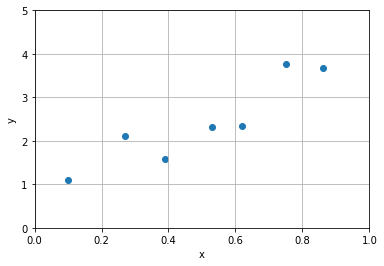

In [ ]:
x = np.array([0.1, 0.27, 0.39, 0.53, 0.62, 0.75, 0.86])
y = np.array([1.09, 2.12, 1.58, 2.31, 2.34, 3.76, 3.67])

def plot_data(data, set_limits=True):
    x, y = data
    plt.scatter(x, y)
    if set_limits:
        plt.xlim(0, 1)
        plt.ylim(
            np.floor(y.min() - 0.5),
            np.ceil(y.max() + 0.5)
        )
    plt.grid()
    plt.xlabel("x")
    plt.ylabel("y")

plot_data(data=(x, y))

Предположим, что переменная $y$ связана с $x$ по линейному закону:

$$y = k\cdot x + b,$$

а отличия от него обусловлены случайнм шумом (напрмер, в связи с неточностью измерений). Описанный выше закон имеет следующие атрибуты:
  - вход ($x$)
  - выход ($y$)
  - параметры ($k$ и $b$)

Отобразим его графически:

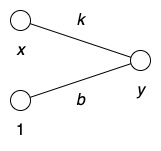

Наша задача — подобрать такие значения параметров $k$ и $b$, чтобы наилучшим образом описать имеющийся у нас набор точек.

Как станет известно чуть позже, линейные законы являются составными частями нейросетевых моделей. Таким образом, для создания модели, работающей по описанному выше закону, мы можем использовать фреймворки разработки нейросетей. В частности, мы используем `tensorflow` и `keras`.

Ниже мы создаём модель типа `Sequential` — это специальный класс для описания моделей, состоящих из набора последовательных преобразований — "слоёв". В нашем случае преобразование лишь одно — линейное. Реализовано оно с помощью слоя `Dense`. В качестве единственного обязательного параметра он принимает размерность выхода — в нашем случае она равна 1 (каждому $x$ соответствует одно число $y$).

In [ ]:
model = keras.Sequential(
    [
        keras.layers.Dense(1),
    ],
)

Итак, мы создали модель, но её параметры ещё не обучены — они лишь были проиницилизированы случайным образом. Ниже мы написали функцию для визуализации предсказаний модели:

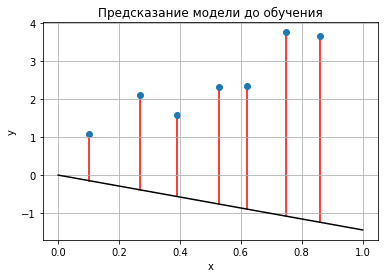

In [ ]:
def plot_model_prediction(model, data):
    x, y = data
    y_pred = model.predict(x.reshape(-1, 1)).squeeze()

    x_grid = np.linspace(0, 1, 100)
    y_pred_grid = model.predict(x_grid.reshape(-1, 1)).squeeze()

    plt.plot(x_grid, y_pred_grid, c="black")
    for ix, iy, iy_pred in zip(x, y, y_pred):
        plt.plot([ix, ix], [iy, iy_pred], c="red", zorder=-1)
    plot_data(data, set_limits=False)

plot_model_prediction(model, data=(x, y))
plt.title("Предсказание модели до обучения");

Как же такую модель обучить? Для начала, нам нужна некоторая функция качества предсказаний нашей модели — **функция потерь** (**loss function** или просто **loss**). Эта функция должна для любого состояния нашей модели ставить в соответствие число: чем оно меньше — тем лучше модель предсказывает данные. На рисунке выше ошибки модели обозначены красными отрезками. Понятно, что мы хотели бы сократить длины этих отрезков — т.е. уменьшить ошибки. Так, в качестве loss-функции можно взять среднее квадратов этих ошибок — **mean squared error**.

Нейросетевые фреймворки умеют для каждого состояния модели определять направление изменения её параметров, соответствующее уменьшению значения loss-функции. Делая шаги вдоль этих направлений, они постепенно уменьшают loss и потому улучшают качество предсказаний модели. Этот процесс называется **оптимизацией**. Существуют различные алгоритмы для определения оптимальных направлений и размеров шагов. Например, ниже мы будем использовать алгоритмы `RMSprop` и `Adam` (их детальное описание выходит за рамки данного материала).

Код ниже выбирает для нашей модели функцию потерь и алгоритм оптимизации, затем совершает итерации обучения. После завершения обучения мы визуализируем **кривую обучения** (**learnig curve**) — то есть зависимость значения функции потерь от номера итерации оптимизации.

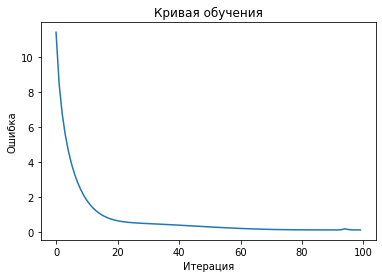

In [ ]:
# Выбор и настройка алгоритма оптимизации и функции потерь:
model.compile(optimizer="RMSprop", loss="mean_squared_error")
model.optimizer.lr.assign(0.1)

# Обучение:
model.fit(x, y, batch_size=7, epochs=100, verbose=0);

# Визуализация кривой обучения:
plt.plot(model.history.history["loss"])
plt.xlabel("Итерация")
plt.ylabel("Ошибка")
plt.title("Кривая обучения");

Посмотрим теперь на предсказание модели:

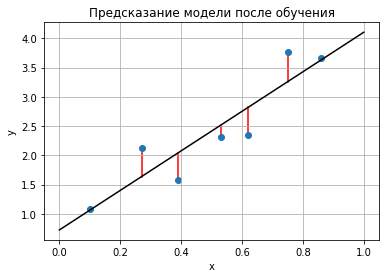

In [ ]:
plot_model_prediction(model, data=(x, y))
plt.title("Предсказание модели после обучения");

Это — лучшее, чего можно было добиться в предположении линейной зависимости между $x$ и $y$. Оставшиеся ошибки связаны только с шумом в наших данных.

### Полиномиальная регрессия

Рассмотрим теперь другой набор точек:

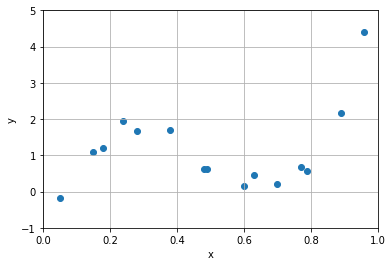

In [ ]:
x = np.array([0.05, 0.15, 0.18, 0.24, 0.28,
              0.38, 0.49, 0.48, 0.6, 0.63,
              0.7, 0.77, 0.79, 0.89, 0.96])
y = np.array([-0.19, 1.08, 1.2, 1.96, 1.66,
              1.7, 0.62, 0.62, 0.15, 0.45,
              0.2, 0.69, 0.57, 2.17, 4.4])

plot_data(data=(x, y))

Видно, что линейным законом эту зависимость уже не описать. Можно усложнить наш закон — вместо линейного взять полином. Например, 3-ей степени:

$$y = k_1\cdot x + k_2\cdot x^2 + k_3\cdot x^3 + b.$$

У нового закона стало больше параметров: $k_1$, $k_2$, $k_3$ и $b$. Выход у него всё так же один — $y$.

На вход же можно посмотреть двумя способами. Можно, например, считать разные степени переменной $x$ — независимыми входами. Тогда графически наша модель будет выглядеть так:

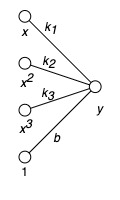

Можно же считать, что вход у нас один — $x$, а его трансформации — часть нашей модели:

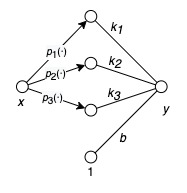

На рисунке выше мы с помощью выражения $p_m(\cdot)$ обозначили возведение в степень $m$. Обратите внимание, что у нас естественным образом возникла многослойность модели.

Новый слой мы реализуем с помощью класса `Lambda` — он позволяет вставить в `Sequential`-модель произвольное функциональное преобразование. Второе же преобразование можно снова описать линейным слоем — `Dense`. Это можно сделать, т.к. наши входы на этом этапе — уже набор различных степеней $x$, а нам лишь нужно взять линейную комбинацию этих степеней.

In [ ]:
# Функция, которая один вход x трансформирует в набор из трёх степеней [x, x^2, x^3]:
def transform_x(x):
    return tf.concat([x, x**2, x**3], axis=1)

model = keras.Sequential(
    [
        keras.layers.Lambda(transform_x),
        keras.layers.Dense(1),
    ],
)

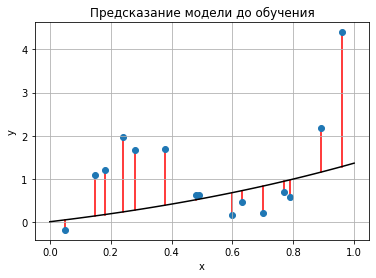

In [ ]:
plot_model_prediction(model, data=(x, y))
plt.title("Предсказание модели до обучения");

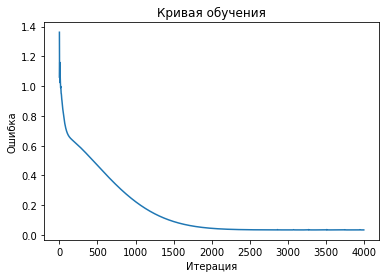

In [ ]:
model.compile(optimizer="Adam", loss="mean_squared_error")
model.optimizer.lr.assign(0.15)

model.fit(x, y, batch_size=15, epochs=4000, verbose=0);

plt.plot(model.history.history["loss"])
plt.xlabel("Итерация")
plt.ylabel("Ошибка")
plt.title("Кривая обучения");

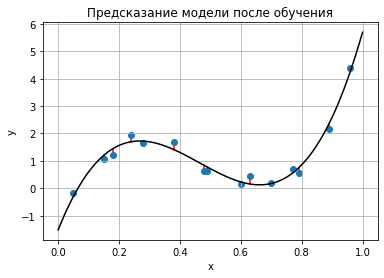

In [ ]:
plot_model_prediction(model, data=(x, y))
plt.title("Предсказание модели после обучения");

### Регрессия нейросетью

В прошлом примере наша модель стала двухслойной, однако обучаемым был только второй слой. Структуру же первого слоя мы "угадали", посмотрев на визуализацию зависимости $y$ от $x$ в данном нам наборе точек и увидев, что нам необходимо преобразование $x\to\left(x, x^2, x^3\right)$. И хотя такой подход в данном случае вполне оправдан, во многих ситуациях найти правильное преобразование входных обектов слишком сложно или вовсе невозможно.

Быть может, если и первый слой сделать обучаемым, такая модель автоматически найдёт правильное преобразование? Но что будет, если просто соединим два линейных слоя, например так?
```python
keras.Sequential(
    [
        keras.layers.Dense(3),
        keras.layers.Dense(1),
    ],
)
```
Графически эта модель будет выглядеть так:

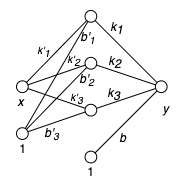

То есть, выходы первого слоя $h_i$ будут равны:

$$h_i = k'_i\cdot x + b'_i,$$

а выход второго:

$$y = h_1\cdot k_1 + h_2\cdot k_2 + h_3\cdot k_3 + b.$$

Если подставить первое уравнение во второе, то можно увидеть, что:

$$y = (k'_1\cdot k_1 + k'_2\cdot k_2 + k'_3\cdot k_3)\cdot x + (k_1\cdot b'_1 + k_2\cdot b'_2 + k_3\cdot b'_3 + b).$$

И хотя такая модель зависит от множества параметров, по сути это оказалась простая линейная модель $y=K\cdot x + B$ с неоправданно сложно заданными коэффициентом наклона ($K=k'_1\cdot k_1 + k'_2\cdot k_2 + k'_3\cdot k_3$) и параметром смещения ($B=k_1\cdot b'_1 + k_2\cdot b'_2 + k_3\cdot b'_3 + b$). То есть, кроме простых прямых линий, ничего другого мы этой моделью построить не сможем.

Что мы продемонстрировали выше — просто свойство линейных преобразований. Комбинация линейных преобразований — тоже линейное преобразование. Здесь нам это свойство мешает — не даёт сделать нашу модель достаточно экспрессивной. Но решить эту проблему можно просто: достаточно лишь добавить какое-то нелинейное преобразование между двумя линейными:

$$h_i\to\sigma(h_i).$$

В качестве такого преобразования можно взять любую нелинейную функцию. Конкретный выбор, однако, повлияет на то, насколько легко получившуюся модель будет оптимизировать. Ниже мы будем использовать функцию ELU (exponential linear unit):

$$
\sigma(x)=\begin{cases}
    x, & \text{if $x\geq 0$},\\
    e^x - 1, & \text{otherwise}.
  \end{cases}
$$

In [ ]:
model = keras.Sequential(
    [
        keras.layers.Dense(1024, activation="elu"),
        keras.layers.Dense(1),
    ],
)

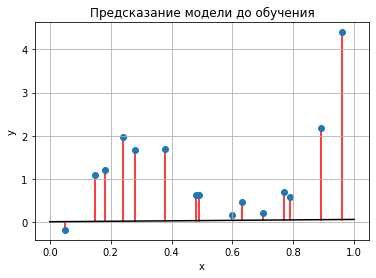

In [ ]:
plot_model_prediction(model, data=(x, y))
plt.title("Предсказание модели до обучения");

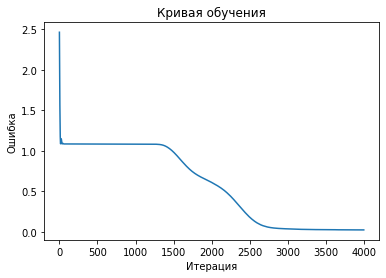

In [ ]:
model.compile(optimizer="Adam", loss="mean_squared_error")
model.fit(x, y, batch_size=15, epochs=4000, verbose=0);

plt.plot(model.history.history["loss"])
plt.xlabel("Итерация")
plt.ylabel("Ошибка")
plt.title("Кривая обучения");

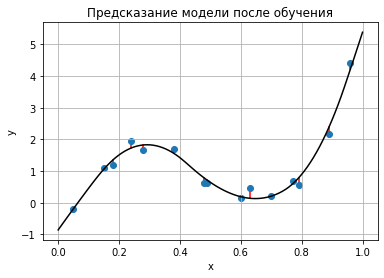

In [ ]:
plot_model_prediction(model, data=(x, y))
plt.title("Предсказание модели после обучения");

Сконструированная таким образом модель оказалась способна описать нужную нам зависимость. На самом деле, такая модель [способна описать **любую** зависимость](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BE%D1%80%D0%B5%D0%BC%D0%B0_%D0%A6%D1%8B%D0%B1%D0%B5%D0%BD%D0%BA%D0%BE), если только взять достаточно большое число выходов первого линейного слоя.

## Часть 2. Практика: классификация углов с помощью нейросети

Продемонстрируем, как нейросетью можно решить задачу классификации — попробуем обучить модель по координатам трёх точек определять, образуют ли они острый или тупой угол.

На самом деле, знания геометрии позволяют нам решить эту задачу абсолютно точно и без использования нейросетей — надо лишь посмотреть на знак скалярного произведения между векторами, образованными парами точек. Используем это знание для создания набора данных, на котором мы будем обучать нашу модель:

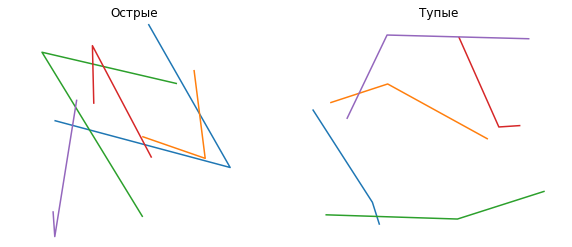

In [ ]:
def is_angle_ABC_acute(xA, yA, xB, yB, xC, yC):
    return ((xA - xB) * (xC - xB) + (yA - yB) * (yC - yB)) > 0

N = 100000
coordinates = np.random.uniform(low=-1.0, high=1.0, size=(N, 6))
angle_accuteness = is_angle_ABC_acute(*coordinates.T).astype("int32")

def draw_angles(coordinates, max_n_angles=5):
    for angle in coordinates[:max_n_angles]:
        plt.plot(*angle.reshape(3, 2).T)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1); plt.axis("off")
draw_angles(coordinates[angle_accuteness == 1])
plt.title("Острые")
plt.xlim(-1, 1); plt.ylim(-1, 1)
plt.subplot(1, 2, 2); plt.axis("off")
draw_angles(coordinates[angle_accuteness == 0])
plt.title("Тупые")
plt.xlim(-1, 1); plt.ylim(-1, 1);

Создание модели практически ничем не отличается от того, как это делалось в прошлом разделе. На этот раз мы добавили еще один слой, увеличив глубину нейросети. Изменилась также функция ошибок — среднеквадратичная ошибка нам тут не подойдёт. В место неё мы возьмём **перекрёстную энтропию** (cross-entropy) — функцию, использование которой мотивировано с точки зрения теории вероятностей.

In [ ]:
model = keras.Sequential(
    layers=[
        keras.layers.Dense(128, activation="elu"),
        keras.layers.Dense(128, activation="elu"),
        keras.layers.Dense(1),
    ],
    name="classifier"
)
model.build(input_shape=(None, 6))
model.compile(
    optimizer="RMSprop",
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.summary()

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               896       
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 17,537
Trainable params: 17,537
Non-trainable params: 0
_________________________________________________________________


Посмотрим на предсказания модели до обучения:

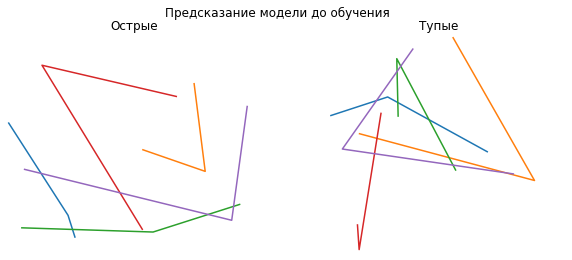

In [ ]:
predicted_accuteness = (model.predict(coordinates).squeeze() > 0).astype("int32")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1); plt.axis("off")
draw_angles(coordinates[predicted_accuteness == 1])
plt.title("Острые")
plt.xlim(-1, 1); plt.ylim(-1, 1)
plt.subplot(1, 2, 2); plt.axis("off")
draw_angles(coordinates[predicted_accuteness == 0])
plt.title("Тупые")
plt.xlim(-1, 1); plt.ylim(-1, 1)
plt.suptitle("Предсказание модели до обучения");

Обучим нашу модель:

In [ ]:
model.fit(x=coordinates, y=angle_accuteness, validation_split=0.5, epochs=10, batch_size=128);

Epoch 1/10
391/391 [==============================] - 2s 4ms/step - loss: 0.3668 - accuracy: 0.8466 - val_loss: 0.1447 - val_accuracy: 0.9563
Epoch 2/10
391/391 [==============================] - 1s 4ms/step - loss: 0.0892 - accuracy: 0.9730 - val_loss: 0.0645 - val_accuracy: 0.9761
Epoch 3/10
391/391 [==============================] - 1s 4ms/step - loss: 0.0540 - accuracy: 0.9814 - val_loss: 0.0496 - val_accuracy: 0.9782
Epoch 4/10
391/391 [==============================] - 1s 3ms/step - loss: 0.0425 - accuracy: 0.9844 - val_loss: 0.0387 - val_accuracy: 0.9835
Epoch 5/10
391/391 [==============================] - 1s 4ms/step - loss: 0.0368 - accuracy: 0.9858 - val_loss: 0.0352 - val_accuracy: 0.9905
Epoch 6/10
391/391 [==============================] - 1s 4ms/step - loss: 0.0324 - accuracy: 0.9878 - val_loss: 0.0322 - val_accuracy: 0.9828
Epoch 7/10
391/391 [==============================] - 1s 4ms/step - loss: 0.0299 - accuracy: 0.9886 - val_loss: 0.0293 - val_accuracy: 0.9886
Epoch 

Посмотрим на кривые обучения:

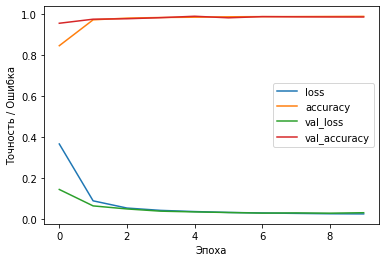

In [ ]:
for k in model.history.history.keys():
    plt.plot(model.history.history[k], label=k)
plt.xlabel("Эпоха")
plt.ylabel("Точность / Ошибка")
plt.legend();

Теперь взглянем на предсказания обученной модели:

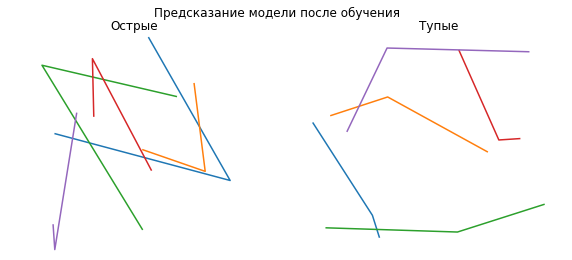

In [ ]:
predicted_accuteness = (model.predict(coordinates).squeeze() > 0).astype("int32")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1); plt.axis("off")
draw_angles(coordinates[predicted_accuteness == 1])
plt.title("Острые")
plt.xlim(-1, 1); plt.ylim(-1, 1)
plt.subplot(1, 2, 2); plt.axis("off")
draw_angles(coordinates[predicted_accuteness == 0])
plt.title("Тупые")
plt.xlim(-1, 1); plt.ylim(-1, 1)
plt.suptitle("Предсказание модели после обучения");

## Часть 3. Генеративно-состязательные сети (GAN)

### Создание новых объектов нейросетями

Мы уже говорили выше, что теоретически нейросети способны аппроксимировать любую зависимость сколь угодно точно. Но это значит, что для любого набора объектов существует нейросеть, которая может трансформировать случайные числа в экземпляры таких объектов:

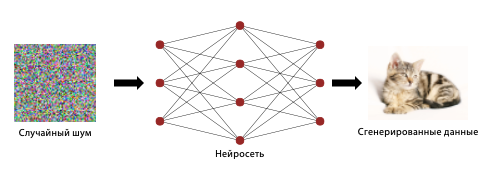

**Котик на картинке выше взят [отсюда](https://pixabay.com/users/chiemsee2016-1892688/)*

Значит, мы можем взять такую нейросеть (назовём её **генератором**) и подавать ей на вход наборы случайных чисел. При этом можно надеяться, что мы сможем обучить этот генератор выдавать что-то осознанное.

### Как обучить генератор?

Как уже говорилось ранее, для обучения нейросети требуется некоторая функция ошибок, характеризующая качество работы модели. Но как измерить качество создания объектов?

Можно попробовать измерить, насколько созданные объекты похожи на объекты из обучающего набора. Но как это сделать? Что, если попробовать обучить еще одну модель для классификации объектов на реальные и сгенерированные? Назовём эту модель **дискриминатором**. Качество модели классификации мы оценивать уже умеем. Понятно, что чем больше сгенерированные объекты похожи на реальные, тем хуже будет качество дискриминатора. Выходит, что в качестве функции потерь генератора можно, например, взять функцию потерь дискриминатора со знаком минус!

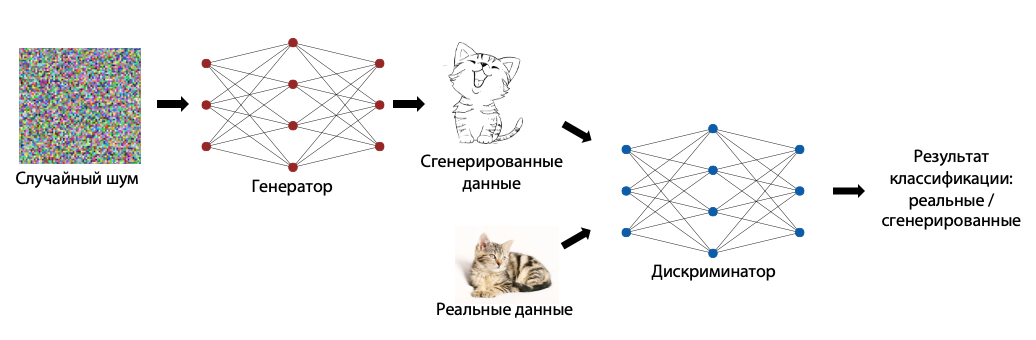

**Рисованный котик взят [отсюда](https://pixabay.com/illustrations/cat-sketch-drawing-graphic-arts-6533387/).*

Таким образом, мы имеем две соревнующиеся нейросети: дискриминатор обучается различать реальные и сгенерированные объекты, а генератор обучается "мешать" дискриминатору это делать.

## Часть 4. Практика: создание изображений лиц людей с помощью генеративно-состязательной сети (GAN)

Скачаем и подготовим набор данных с лицами людей. По нему мы будем обучаться.

In [ ]:
lfw = tfds.image_classification.LFW()
lfw.download_and_prepare()
ds = lfw.as_dataset()

def get_img(x):
  return x['image'][80:-80,80:-80]

data = np.array([
  np.array(Image.fromarray(img.numpy()).resize((36, 36)))
  for img in tqdm(ds['train'].map(get_img))
]).astype(np.float32) / 255.0

sys.stdout.flush()
print("\nshape:", data.shape)
print("min, max:", data.min(), data.max())

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/lfw/0.1.0.incomplete72DSJ3/lfw-train.tfrecord


  0%|          | 0/13233 [00:00<?, ? examples/s]

Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


100%|██████████| 13233/13233 [00:13<00:00, 959.85it/s]



shape: (13233, 36, 36, 3)
min, max: 0.0 1.0


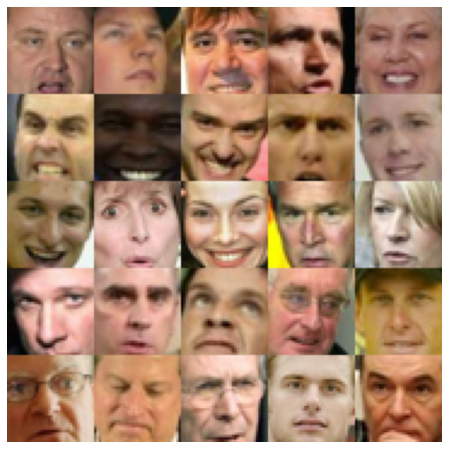

In [ ]:
def plot_mn(images, m=5, n=5, shuffle=True):
  if shuffle:
    images = images[np.random.permutation(len(images))[:m * n]]
  _, h, w, _ = images.shape
  images = images[:m*n].reshape(m, n, *images.shape[1:])
  images = images.transpose(0, 2, 1, 3, 4).reshape(m * h, n * w, -1)
  plt.imshow(images)

plt.figure(figsize=(8, 8))
plot_mn(data, shuffle=False)
plt.axis('off');

Ранее мы полагались на модель `Sequential`. Мы всё ещё можем использовать её для генератора и дискриминатора по отдельности, но на описание всей совокупной системы её не хватит. Код ниже берёт за основу класс `Model` из `keras` и расширяет его функционал под наши цели.

В конструкторе (`__init__`), то есть в момент создания нашей модели мы создаём и настраиваем архитектуры генератора и дискриминатора. Мы также создаём их "замороженные" копии — они позволят нам сделать так, чтобы оптимизация функции потерь дискриминатора не влияла на состояние генератора и наоборот. Другими словами, при расчетё функции потерь дискриминатора мы будем использовать "замороженный" генератор:

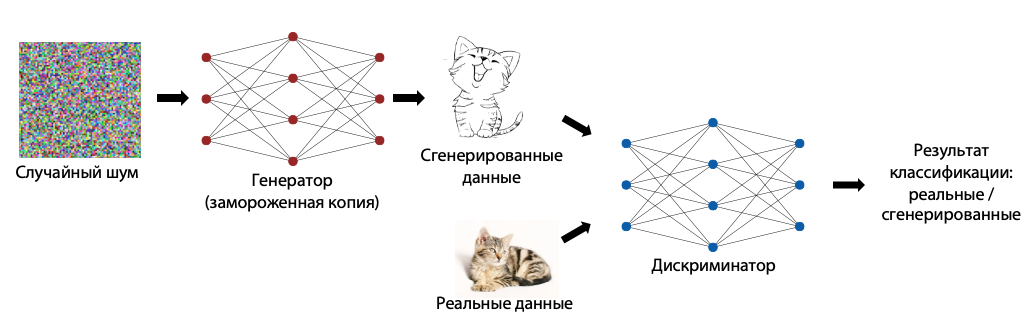

А при расчёте функции потерь генератора — замороженный дискриминатор (при расчете функции потерь генератора мы также можем не делать подстановку реальных данных в дискриминатор):

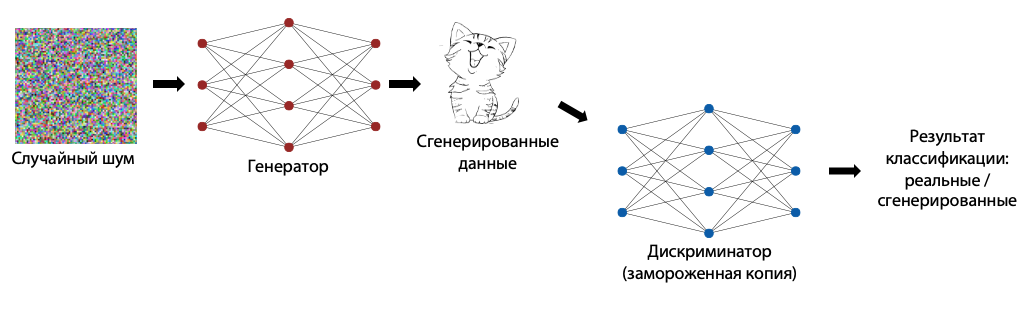

На практике нам потребуется периодически синхронизировать состояния обучаемых нейросетей и их "замороженных" копий. Для этого мы реализовали метод `update_frozen_models`, внутри которого значения параметров обучаемых моделей просто копируются в параметры "замороженных".

> *На самом деле, это копирование лишь замедляет исполнение кода. В принципе, есть способ обойтись без него и без "замороженных" копий вообще, однако это сделает код более сложным для объяснения и потребует погружения в некоторые детали.*

Мы также реализовали в виде отдельного метода `generate_images` создание изображений генератором. Его параметр `frozen` управляет тем, какую из версий генератора для этого использовать: обучаемую или "замороженную".

Наконец, всё самое интересное происходит внутри метода `call`. Это специальный метод, который должен быть реализован для любой модели в `keras`. Он будет автоматически вызываться на каждом шаге обучения. Внутри него мы должны вычислить значение функции потерь и задекларировать его с помощью вызова `self.add_loss` — так алгоритм оптимизации поймёт, что именно ему нужно оптимизировать. Поскольку наша полная модель состоит из двух нейросетей — у каждой из них будет своя функция потерь (`g_loss` и `(d_loss_0 + d_loss_1) / 2` у генератора и дискриминатора, соответственно), а полная функция потерь будет их взвешенной суммой. В методе `call` мы также пару раз вызываем `self.add_metric` — это мы делаем для мониторинга значений различных компонент нашей полной функции потерь.

In [ ]:
class GAN(keras.Model):
    def __init__(self, latent_dims=128, **kwargs):
        super().__init__(**kwargs)

        self.latent_dims = latent_dims
        self.generator = keras.Sequential(
            layers=[
                keras.layers.Dense(64, activation="elu"),
                keras.layers.Dense(3 * 36 * 36),
                keras.layers.Reshape((36, 36, 3)),
            ],
            name="generator"
        )

        self.discriminator = keras.Sequential(
            layers=[
                keras.layers.Reshape((3 * 36 * 36,)),
                keras.layers.Dense(128, activation="elu"),
                keras.layers.Dense(1),
            ],
            name="discriminator"
        )

        self.generator.build(input_shape=(None, self.latent_dims))
        self.discriminator.build(input_shape=(None, 36, 36, 3))

        self.frozen_generator = keras.models.clone_model(self.generator)
        self.frozen_discriminator = keras.models.clone_model(self.discriminator)
        self.frozen_generator.trainable = False
        self.frozen_discriminator.trainable = False

    def generate_images(self, num_images, frozen=False):
        if frozen:
            generator = self.frozen_generator
        else:
            generator = self.generator
        return generator(
            tf.random.normal(shape=(num_images, self.latent_dims))
        )

    def update_frozen_models(self):
        for w_src, w_target in zip(
            self.generator.weights + self.discriminator.weights,
            self.frozen_generator.weights + self.frozen_discriminator.weights,
        ):
            w_target.assign(w_src)

    def call(self, inputs):
        images_real = inputs

        batch_size = tf.shape(images_real)[0]
        self.update_frozen_models()

        images_gen = self.generate_images(batch_size, frozen=False)
        images_gen_frozen = self.generate_images(batch_size, frozen=True)

        # Создадим массивы единиц и нулей - они будут обозначать, принадлежит ли данная
        # каритнка к классу реальных или сгенерированных
        labels_1 = tf.ones((batch_size, 1))
        labels_0 = tf.zeros((batch_size, 1))

        # Обучение дискриминатора
        d_loss_0 = self.compiled_loss(labels_0, self.discriminator(images_gen_frozen))
        d_loss_1 = self.compiled_loss(labels_1, self.discriminator(images_real))
        self.add_metric((d_loss_0 + d_loss_1) / 2, name="d_loss")

        # Обучение генератора. Вместо взятия функции потерь дискриминатора со знаком "минус",
        # мы можем взять её со знаком "плюс", но заменить нули на единицы (как если бы это
        # были реальные картинки, а не сгенерированные).
        g_loss = self.compiled_loss(labels_1, self.frozen_discriminator(images_gen))
        self.add_metric(g_loss, name="g_loss")

        self.add_loss(d_loss_0 + d_loss_1 + 0.25 * g_loss)

        return images_gen


gan = GAN()
gan.compile("RMSprop", loss=keras.losses.BinaryCrossentropy(from_logits=True))
gan(data[:1])
gan.summary()

Model: "gan_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator (Sequential)       (None, 36, 36, 3)         260976    
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 497921    
_________________________________________________________________
generator (Sequential)       (None, 36, 36, 3)         260976    
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 497921    
Total params: 1,517,794
Trainable params: 758,897
Non-trainable params: 758,897
_________________________________________________________________


Было бы неплохо периодически по мере обучения нашей модели смотреть на то, какие картинки она умеет создавать в тот или иной момент. Для этой цели мы реализуем специальный класс `Callback` — его метод `on_epoch_end` будет автоматически вызываться в конце каждой эпохи, и раз в несколько вызовов мы будем внутри него создавать генератором картинки и отрисовывать их.

In [ ]:
class PlotImgsCallback(keras.callbacks.Callback):
    def __init__(self, period_in_epochs=5):
        super().__init__()
        self.period_in_epochs = period_in_epochs

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.period_in_epochs == 0:
            plt.figure(figsize=(2, 2))
            plot_mn(self.model.generate_images(25).numpy().clip(0, 1))
            plt.axis("off")
            plt.show()

Теперь всё готово к обучению нашей модели! Приступим:

Epoch 1/100
207/207 [==============================] - 6s 21ms/step - loss: 0.8498 - d_loss: 0.8401 - g_loss: 0.8546
Epoch 2/100
207/207 [==============================] - 4s 21ms/step - loss: 1.0637 - d_loss: 1.0291 - g_loss: 1.1152
Epoch 3/100
207/207 [==============================] - 4s 21ms/step - loss: 1.0829 - d_loss: 1.0950 - g_loss: 1.0370
Epoch 4/100
207/207 [==============================] - 4s 21ms/step - loss: 1.0794 - d_loss: 1.0860 - g_loss: 1.0457
Epoch 5/100
207/207 [==============================] - 4s 20ms/step - loss: 1.0156 - d_loss: 0.9932 - g_loss: 1.0399


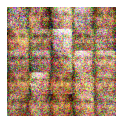

Epoch 6/100
207/207 [==============================] - 4s 20ms/step - loss: 0.9402 - d_loss: 0.9201 - g_loss: 0.9632
Epoch 7/100
207/207 [==============================] - 4s 21ms/step - loss: 0.8466 - d_loss: 0.8250 - g_loss: 0.8731
Epoch 8/100
207/207 [==============================] - 4s 21ms/step - loss: 0.8242 - d_loss: 0.8018 - g_loss: 0.8537
Epoch 9/100
207/207 [==============================] - 4s 21ms/step - loss: 0.7861 - d_loss: 0.7605 - g_loss: 0.8231
Epoch 10/100
207/207 [==============================] - 4s 20ms/step - loss: 0.8036 - d_loss: 0.7908 - g_loss: 0.8136


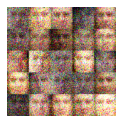

Epoch 11/100
207/207 [==============================] - 4s 21ms/step - loss: 0.7461 - d_loss: 0.7236 - g_loss: 0.7774
Epoch 12/100
207/207 [==============================] - 4s 21ms/step - loss: 0.7188 - d_loss: 0.6986 - g_loss: 0.7456
Epoch 13/100
207/207 [==============================] - 4s 21ms/step - loss: 0.7114 - d_loss: 0.6933 - g_loss: 0.7342
Epoch 14/100
207/207 [==============================] - 4s 21ms/step - loss: 0.7122 - d_loss: 0.6932 - g_loss: 0.7366
Epoch 15/100
207/207 [==============================] - 4s 21ms/step - loss: 0.7107 - d_loss: 0.6928 - g_loss: 0.7333


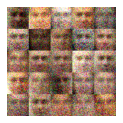

Epoch 16/100
207/207 [==============================] - 4s 21ms/step - loss: 0.7090 - d_loss: 0.6924 - g_loss: 0.7286
Epoch 17/100
207/207 [==============================] - 4s 21ms/step - loss: 0.7093 - d_loss: 0.6922 - g_loss: 0.7299
Epoch 18/100
207/207 [==============================] - 4s 21ms/step - loss: 0.7067 - d_loss: 0.6901 - g_loss: 0.7266
Epoch 19/100
207/207 [==============================] - 4s 22ms/step - loss: 0.7068 - d_loss: 0.6901 - g_loss: 0.7269
Epoch 20/100
207/207 [==============================] - 4s 21ms/step - loss: 0.7081 - d_loss: 0.6905 - g_loss: 0.7297


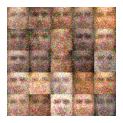

Epoch 21/100
207/207 [==============================] - 5s 22ms/step - loss: 0.7060 - d_loss: 0.6878 - g_loss: 0.7291
Epoch 22/100
207/207 [==============================] - 4s 22ms/step - loss: 0.7095 - d_loss: 0.6905 - g_loss: 0.7341
Epoch 23/100
207/207 [==============================] - 5s 22ms/step - loss: 0.7096 - d_loss: 0.6902 - g_loss: 0.7354
Epoch 24/100
207/207 [==============================] - 4s 22ms/step - loss: 0.7079 - d_loss: 0.6907 - g_loss: 0.7291
Epoch 25/100
207/207 [==============================] - 5s 22ms/step - loss: 0.7103 - d_loss: 0.6922 - g_loss: 0.7333


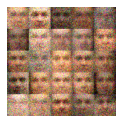

Epoch 26/100
207/207 [==============================] - 5s 22ms/step - loss: 0.7087 - d_loss: 0.6940 - g_loss: 0.7246
Epoch 27/100
207/207 [==============================] - 5s 22ms/step - loss: 0.7073 - d_loss: 0.6919 - g_loss: 0.7248
Epoch 28/100
207/207 [==============================] - 5s 22ms/step - loss: 0.7090 - d_loss: 0.6934 - g_loss: 0.7267
Epoch 29/100
207/207 [==============================] - 5s 22ms/step - loss: 0.7081 - d_loss: 0.6939 - g_loss: 0.7230
Epoch 30/100
207/207 [==============================] - 5s 22ms/step - loss: 0.7071 - d_loss: 0.6933 - g_loss: 0.7211


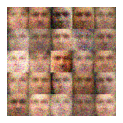

Epoch 31/100
207/207 [==============================] - 5s 22ms/step - loss: 0.7061 - d_loss: 0.6918 - g_loss: 0.7210
Epoch 32/100
207/207 [==============================] - 5s 22ms/step - loss: 0.7092 - d_loss: 0.6930 - g_loss: 0.7282
Epoch 33/100
207/207 [==============================] - 5s 22ms/step - loss: 0.7070 - d_loss: 0.6922 - g_loss: 0.7232
Epoch 34/100
207/207 [==============================] - 5s 22ms/step - loss: 0.7074 - d_loss: 0.6918 - g_loss: 0.7256
Epoch 35/100
207/207 [==============================] - 5s 22ms/step - loss: 0.7057 - d_loss: 0.6907 - g_loss: 0.7223


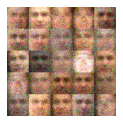

Epoch 36/100
207/207 [==============================] - 5s 22ms/step - loss: 0.7055 - d_loss: 0.6900 - g_loss: 0.7233
Epoch 37/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7051 - d_loss: 0.6904 - g_loss: 0.7212
Epoch 38/100
207/207 [==============================] - 5s 22ms/step - loss: 0.7071 - d_loss: 0.6906 - g_loss: 0.7266
Epoch 39/100
207/207 [==============================] - 5s 22ms/step - loss: 0.7066 - d_loss: 0.6907 - g_loss: 0.7250
Epoch 40/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7069 - d_loss: 0.6906 - g_loss: 0.7260


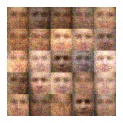

Epoch 41/100
207/207 [==============================] - 5s 22ms/step - loss: 0.7060 - d_loss: 0.6902 - g_loss: 0.7241
Epoch 42/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7059 - d_loss: 0.6897 - g_loss: 0.7249
Epoch 43/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7085 - d_loss: 0.6911 - g_loss: 0.7301
Epoch 44/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7063 - d_loss: 0.6890 - g_loss: 0.7275
Epoch 45/100
207/207 [==============================] - 5s 22ms/step - loss: 0.7055 - d_loss: 0.6888 - g_loss: 0.7252


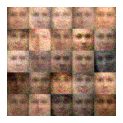

Epoch 46/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7065 - d_loss: 0.6891 - g_loss: 0.7278
Epoch 47/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7062 - d_loss: 0.6886 - g_loss: 0.7284
Epoch 48/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7074 - d_loss: 0.6888 - g_loss: 0.7311
Epoch 49/100
207/207 [==============================] - 5s 22ms/step - loss: 0.7057 - d_loss: 0.6874 - g_loss: 0.7293
Epoch 50/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7064 - d_loss: 0.6883 - g_loss: 0.7292


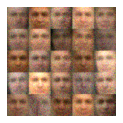

Epoch 51/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7059 - d_loss: 0.6876 - g_loss: 0.7291
Epoch 52/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7089 - d_loss: 0.6909 - g_loss: 0.7314
Epoch 53/100
207/207 [==============================] - 5s 22ms/step - loss: 0.7071 - d_loss: 0.6877 - g_loss: 0.7326
Epoch 54/100
207/207 [==============================] - 5s 22ms/step - loss: 0.7068 - d_loss: 0.6873 - g_loss: 0.7322
Epoch 55/100
207/207 [==============================] - 5s 22ms/step - loss: 0.7065 - d_loss: 0.6857 - g_loss: 0.7347


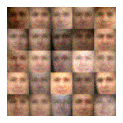

Epoch 56/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7061 - d_loss: 0.6863 - g_loss: 0.7323
Epoch 57/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7069 - d_loss: 0.6863 - g_loss: 0.7344
Epoch 58/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7056 - d_loss: 0.6870 - g_loss: 0.7298
Epoch 59/100
207/207 [==============================] - 5s 22ms/step - loss: 0.7067 - d_loss: 0.6884 - g_loss: 0.7297
Epoch 60/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7083 - d_loss: 0.6893 - g_loss: 0.7331


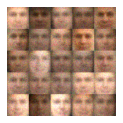

Epoch 61/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7056 - d_loss: 0.6856 - g_loss: 0.7323
Epoch 62/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7064 - d_loss: 0.6865 - g_loss: 0.7328
Epoch 63/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7063 - d_loss: 0.6863 - g_loss: 0.7335
Epoch 64/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7067 - d_loss: 0.6895 - g_loss: 0.7275
Epoch 65/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7082 - d_loss: 0.6873 - g_loss: 0.7368


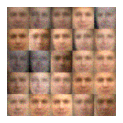

Epoch 66/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7055 - d_loss: 0.6853 - g_loss: 0.7327
Epoch 67/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7080 - d_loss: 0.6841 - g_loss: 0.7427
Epoch 68/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7074 - d_loss: 0.6844 - g_loss: 0.7401
Epoch 69/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7069 - d_loss: 0.6841 - g_loss: 0.7394
Epoch 70/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7073 - d_loss: 0.6788 - g_loss: 0.7509


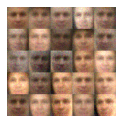

Epoch 71/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7082 - d_loss: 0.6798 - g_loss: 0.7523
Epoch 72/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7070 - d_loss: 0.6803 - g_loss: 0.7472
Epoch 73/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7087 - d_loss: 0.6763 - g_loss: 0.7606
Epoch 74/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7100 - d_loss: 0.6799 - g_loss: 0.7569
Epoch 75/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7107 - d_loss: 0.6758 - g_loss: 0.7678


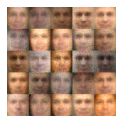

Epoch 76/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7078 - d_loss: 0.6716 - g_loss: 0.7673
Epoch 77/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7102 - d_loss: 0.6703 - g_loss: 0.7767
Epoch 78/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7106 - d_loss: 0.6693 - g_loss: 0.7801
Epoch 79/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7137 - d_loss: 0.6673 - g_loss: 0.7949
Epoch 80/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7116 - d_loss: 0.6660 - g_loss: 0.7901


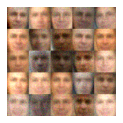

Epoch 81/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7142 - d_loss: 0.6672 - g_loss: 0.7954
Epoch 82/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7131 - d_loss: 0.6609 - g_loss: 0.8045
Epoch 83/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7155 - d_loss: 0.6626 - g_loss: 0.8082
Epoch 84/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7144 - d_loss: 0.6560 - g_loss: 0.8188
Epoch 85/100
207/207 [==============================] - 5s 24ms/step - loss: 0.7150 - d_loss: 0.6534 - g_loss: 0.8259


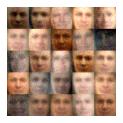

Epoch 86/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7148 - d_loss: 0.6543 - g_loss: 0.8229
Epoch 87/100
207/207 [==============================] - 5s 24ms/step - loss: 0.7190 - d_loss: 0.6529 - g_loss: 0.8385
Epoch 88/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7165 - d_loss: 0.6504 - g_loss: 0.8362
Epoch 89/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7198 - d_loss: 0.6504 - g_loss: 0.8467
Epoch 90/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7173 - d_loss: 0.6490 - g_loss: 0.8413


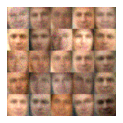

Epoch 91/100
207/207 [==============================] - 5s 24ms/step - loss: 0.7197 - d_loss: 0.6502 - g_loss: 0.8461
Epoch 92/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7220 - d_loss: 0.6470 - g_loss: 0.8594
Epoch 93/100
207/207 [==============================] - 5s 24ms/step - loss: 0.7191 - d_loss: 0.6437 - g_loss: 0.8583
Epoch 94/100
207/207 [==============================] - 5s 24ms/step - loss: 0.7224 - d_loss: 0.6439 - g_loss: 0.8675
Epoch 95/100
207/207 [==============================] - 5s 24ms/step - loss: 0.7210 - d_loss: 0.6413 - g_loss: 0.8681


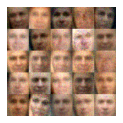

Epoch 96/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7237 - d_loss: 0.6413 - g_loss: 0.8768
Epoch 97/100
207/207 [==============================] - 5s 24ms/step - loss: 0.7225 - d_loss: 0.6401 - g_loss: 0.8747
Epoch 98/100
207/207 [==============================] - 5s 23ms/step - loss: 0.7243 - d_loss: 0.6414 - g_loss: 0.8776
Epoch 99/100
207/207 [==============================] - 5s 24ms/step - loss: 0.7223 - d_loss: 0.6376 - g_loss: 0.8794
Epoch 100/100
207/207 [==============================] - 5s 24ms/step - loss: 0.7227 - d_loss: 0.6342 - g_loss: 0.8875


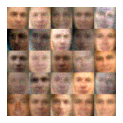

In [ ]:
gan.fit(data, batch_size=64, epochs=100, callbacks=PlotImgsCallback())

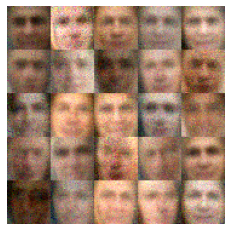

In [ ]:
plot_mn(gan.generate_images(25).numpy().clip(0, 1))
plt.axis("off");

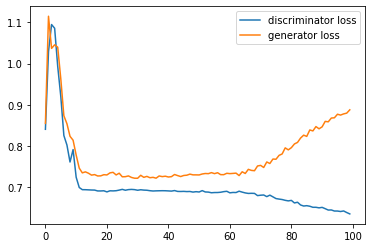

In [ ]:
plt.plot(gan.history.history["d_loss"], label="discriminator loss");
plt.plot(gan.history.history["g_loss"], label="generator loss");
plt.legend();

## Некоторые примеры применения

  - https://thispersondoesnotexist.com/ — лица несуществующих людей
  - [pix2pix](https://affinelayer.com/pixsrv/) — реалистичный котик по вашему рисунку
  - [SRGAN](https://medium.com/analytics-vidhya/super-resolution-gan-srgan-5e10438aec0c) — повышение разрешения изображений
  - [Learning Beyond Human Expertise with Generative Models for Dental Restorations](https://arxiv.org/abs/1804.00064) — создание зубных протезов
  - [Симуляция детектора физики частиц](https://doi.org/10.1140/epjc/s10052-021-09366-4) (и еще [несколько десятков применений](https://github.com/iml-wg/HEPML-LivingReview) в этой области)